In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import idct
import functions as f
import tests as t

from sys import path


path.append("/home/huseyin/pybrain-master/")

%matplotlib inline

/home/huseyin/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Tests / Data Preparation

In [3]:
_ = t.run_tests()

flatten_recreate_test:		passed
rescale_max_check_test:		passed
rescale_max_check_test_2:	passed
rescale_data_check_test:	passed
convert_to_z_test:		passed
convert_to_z_test_2:		passed
convert_to_z_test_3:		passed
preprocessing_test:		passed
make_chunks_test:		passed
confusion_matrix_test:		passed


In [4]:
args = {"names": ["carpet1", "carpet2", "carpet3", "carpet4", "carpet5", "desk1", "desk2", "desk3", \
                  "desk4", "desk5", "tiles1", "tiles2", "tiles3", "tiles4", "tiles5"], \
        "dim":168, "classes": np.array([0, 1, 2])}

begin_cutoff = 0
len_segment = 1239
n_mfcc = 13
n_joints = 25

mfcc = np.zeros((len_segment, n_mfcc, len(args["names"])))
j_input = np.zeros((len_segment, 2*n_joints, len(args["names"])))

for i, n  in enumerate(args["names"]):
    name = "mfccJoints_" + n + ".txt"
    temp = np.genfromtxt(name, delimiter = " ")
    mfcc[:, :, i] = f.get_mfcc(temp)[:len_segment, :]
    for j in range(n_joints):
        j_input[:, j, i] = f.get_position(j, temp)[:len_segment, 0]
        j_input[:, j+n_joints, i] = f.get_position(j, temp)[:len_segment, 1] - f.get_position(j, temp)[:len_segment, 0]
        
mfcc = mfcc[begin_cutoff:, :, :]
j_input = j_input[begin_cutoff:, :, :]

In [125]:
def sync_mfcc(mfcc, sync_period = [0, -1], reference = 0, component = 0):
    
    shifted_mfcc = np.zeros(mfcc.shape)
    n_walks = mfcc.shape[2]
    #inter_mfcc_phase = np.zeros(n_walks)
    
    for walk in range(0, n_walks):
        #Optimal size for one cycle
        err = np.zeros(100)
        ind_ = np.arange(-50, 50)

        for i1, i2 in enumerate(ind_):
            #mfcc[:, 0, 0] is reference, we compare everything else
            err[i1] = np.sum(np.abs(mfcc[sync_period[0]:sync_period[1], component, reference] -
                      np.roll(mfcc[sync_period[0]:sync_period[1], component, walk], i2)))

        phase = int(ind_[np.argmin(err)])
        #print phase
        shifted_mfcc[:, :, walk] = np.roll(mfcc[:, :, walk], phase, axis = 0)

    return shifted_mfcc


sh_mfcc = sync_mfcc(mfcc, [250, 750])
sh_j_input = sync_mfcc(j_input, [0, -1])
    

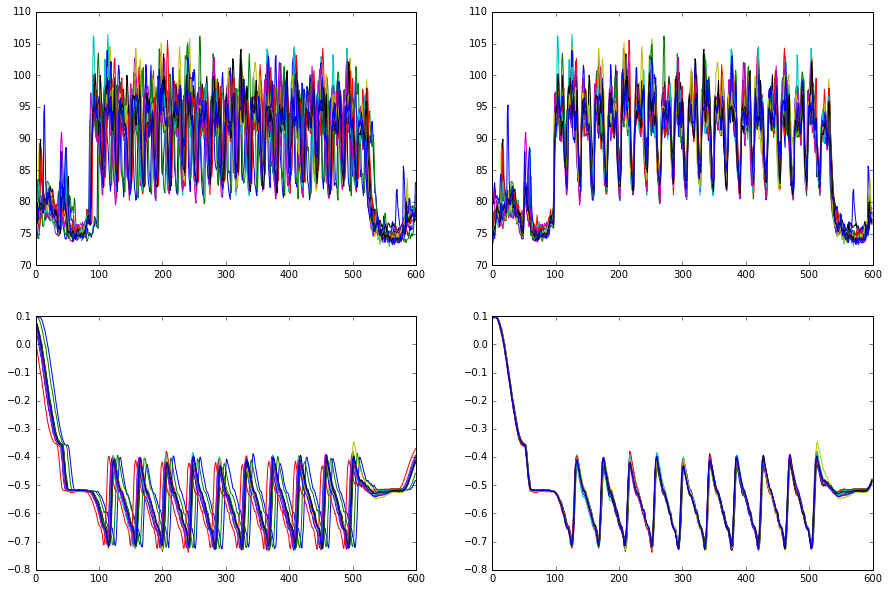

In [126]:
plt.figure(figsize = (15,10))
plt.subplot(221)
plt.plot(mfcc[200:800, 0, :])
plt.subplot(222)
plt.plot(sh_mfcc[200:800, 0, :])
plt.subplot(223)
plt.plot(j_input[200:800, 14, :])
plt.subplot(224)
plt.plot(sh_j_input[200:800, 14, :])
plt.show()

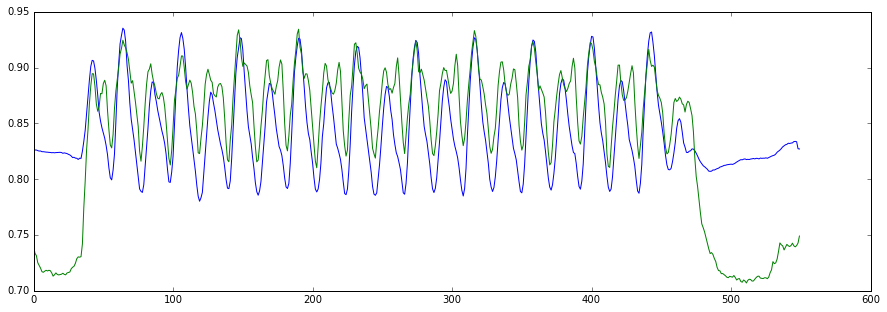

In [127]:
average_walking_joint = np.average(np.sum(j_input[:, f.get_walking_joints(), :], axis = 1), axis = 1)
average_mfcc_signal = np.average(mfcc[:, 0, :], axis = 1)
average_walking_joint = np.abs(average_walking_joint/np.max(np.abs(average_walking_joint)))
average_mfcc_signal = average_mfcc_signal/np.max(np.abs(average_mfcc_signal))

plt.figure(figsize = (15,5))
plt.plot(np.roll(average_walking_joint[250:800], -2) + 0.41)
plt.plot(average_mfcc_signal[250:800])

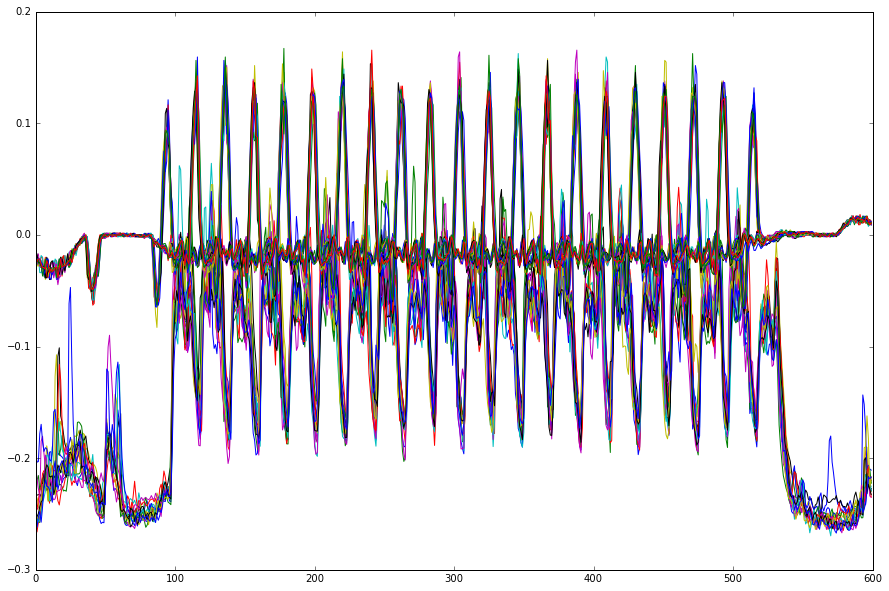

In [124]:
sh_j_input = np.roll(sh_j_input, -2, axis = 0)

plt.figure(figsize = (15,10))
plt.plot(sh_mfcc[200:800, 0, :]/100. - 1)
plt.plot(sh_j_input[200:800, 2+25, :])
plt.plot(sh_j_input[200:800, 14+25, :])
plt.show()

In [128]:
np.savez("synced_data.npz", sh_j_input, sh_mfcc)